In [ ]:
# ❌ Uninstall ALL conflicting packages
!pip uninstall -y numpy open3d scipy scikit-learn tensorboard jax jaxlib

# ✅ Install specific versions that are compatible with Open3D-ML
!pip install numpy==1.24.4 scipy==1.10.1 scikit-learn==1.2.2 --quiet
!pip install open3d==0.19.0 tensorboard==2.18.0 --quiet
!pip install torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cu121 --quiet

# 🔄 Force runtime restart (required to apply numpy version properly)
import os
os.kill(os.getpid(), 9)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 108.7 MB/s eta 0:00:00
ERROR:

In [ ]:
import numpy as np
import open3d as o3d
import open3d.ml as _ml3d
import open3d.ml.torch as ml3d

In [ ]:
# ⚙️ SYSTEM SETUP
!sudo apt-get install -y build-essential

# ✅ Install Open3D and required packages
!pip install open3d pyyaml scikit-learn matplotlib gdown cython

# ✅ Create pretrained folder
!mkdir -p pretrained_model

# ✅ Download pre-trained model (RandLA checkpoint)
!gdown 1SsjF4FxK9cuRu-5NzVuTJ8R4vBLi2w5z -O pretrained_model/checkpoint.tar

# ✅ Compile nearest neighbor ops (KNN)
%cd utils/nearest_neighbors
!python setup.py build_ext --inplace
%cd ../../

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1SsjF4FxK9cuRu-5NzVuTJ8R4vBLi2w5z

but Gdown can't. Please check connections and permissions.
[Errno 2] No such file or directory: 'utils/nearest_neighbors'
/content
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory
/


In [ ]:
# Define the path to your point cloud file
pointcloud_path = "/content/RandLA-Net-pytorch/38002892_icp_merged.bin" # Example path, adjust if needed

# Load .bin file manually
try:
    # Assuming XYZ format (3 float32 values per point)
    points = np.fromfile(pointcloud_path, dtype=np.float32).reshape(-1, 3)
    print(f"Successfully loaded data from: {pointcloud_path}")
    print(f"Shape of loaded points: {points.shape}")

    # Create an Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    print("Created Open3D point cloud object.")

except FileNotFoundError:
    print(f"❌ Error: File not found at {pointcloud_path}")
except ValueError:
    print(f"❌ Error: Could not reshape the data from {pointcloud_path}. Check the dtype and shape.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

Successfully loaded data from: /content/RandLA-Net-pytorch/38002892_icp_merged.bin
Shape of loaded points: (1031675, 3)
Created Open3D point cloud object.


In [ ]:
# Load the correct YAML config
cfg = _ml3d.utils.Config.load_from_file("/content/RandLA-Net-pytorch/utils/semantic-kitti_2.yaml")

# Set the path to your local checkpoint file (manually override if needed)
cfg.model["ckpt_path"] = "/content/RandLA-Net-pytorch/pretrained_model/checkpoint.tar"

# Build the pipeline
pipeline = ml3d.pipelines.SemanticSegmentation(
    model=ml3d.models.RandLANet(**cfg.model),
    device="cuda",  # or "cpu"
    **cfg.pipeline
)

In [ ]:
# Load the pretrained weights
pipeline.load_ckpt()

# Path to your point cloud file
pointcloud_path = "/content/RandLA-Net-pytorch/38002892_icp_merged.bin"

# Load and preprocess point cloud
points = np.fromfile(pointcloud_path, dtype=np.float32).reshape(-1, 3)
data = {
    'point': points,
    'label': np.zeros((points.shape[0],), dtype=np.int32)  # Dummy label array
}


# Run inference
result = pipeline.run_inference(data)

# Output results
print("✅ Predicted labels shape:", result["predict_labels"].shape)
print("First 10 predicted labels:", result["predict_labels"][:10])

# Visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

unique_labels = np.unique(result["predict_labels"])
label_to_color = {label: np.random.rand(3) for label in unique_labels}
colors = np.array([label_to_color[label] for label in result["predict_labels"]])
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.io.write_point_cloud("38002892_merged_predicted.ply", pcd, write_ascii=False)
print("✅ Saved as 38002892_merged_predicted.ply")

test 0/1: 100%|██████████| 219549/219549 [01:21<00:00, 1242.25it/s]/usr/local/lib/python3.11/dist-packages/open3d/_ml3d/torch/modules/metrics/semseg_metric.py:54: RuntimeWarning: Mean of empty slice
  accs.append(np.nanmean(accs))
/usr/local/lib/python3.11/dist-packages/open3d/_ml3d/torch/modules/metrics/semseg_metric.py:87: RuntimeWarning: Mean of empty slice
  ious.append(np.nanmean(ious))


✅ Predicted labels shape: (1031675,)
First 10 predicted labels: [10 10 10 10 10 10 10 10 10 10]
✅ Saved as 38002892_merged_predicted.ply


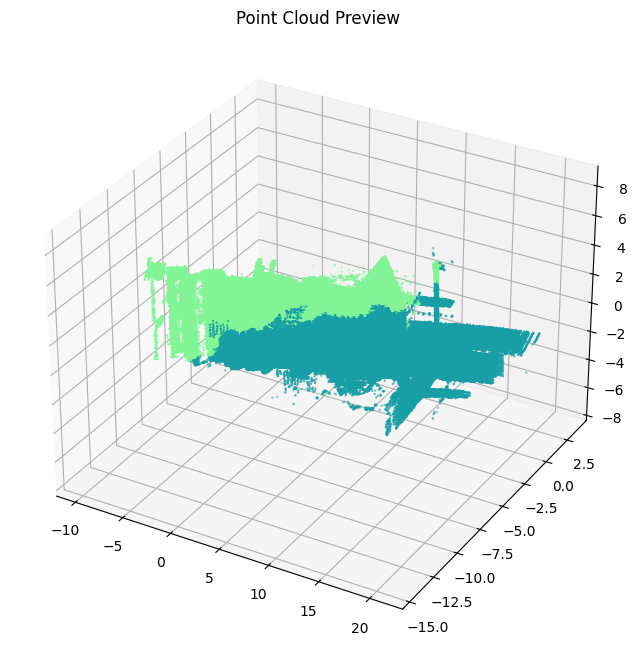

In [ ]:
import matplotlib.pyplot as plt

xyz = np.asarray(pcd.points)
color = np.asarray(pcd.colors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=color, s=0.5)
ax.set_title("Point Cloud Preview")
plt.show()

In [ ]:
import open3d as o3d
import numpy as np

# Assuming `points` is (N, 3) and `predicted_labels` is (N,)
# Assign a color to each unique label
unique_labels = np.unique(result["predict_labels"])
label_to_color = {
    label: np.random.rand(3) for label in unique_labels
}
colors = np.array([label_to_color[label] for label in result["predict_labels"]])

# Center the cloud
points_centered = points - np.mean(points, axis=0)

# Create point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_centered)
pcd.colors = o3d.utility.Vector3dVector(np.clip(colors, 0, 1))

# Save for ATIS (ASCII format preferred)
o3d.io.write_point_cloud("edited_atis_output.ply", pcd, write_ascii=True)
print("✅ Exported centered and colored point cloud to atis_output.ply")

✅ Exported centered and colored point cloud to atis_output.ply


In [ ]:
!pip install open3d laspy

In [ ]:
import laspy

In [ ]:
# Load PLY file from /content
ply_path = "/atis_output.ply"
pcd = o3d.io.read_point_cloud(ply_path)

In [ ]:
# Extract point coordinates
points = np.asarray(pcd.points)

# Handle colors
if pcd.has_colors():
    colors = np.asarray(pcd.colors)
else:
    colors = np.full_like(points, 0.5)  # mid-gray

# Convert color values from [0, 1] to [0, 65535] for LAS
colors_16bit = (colors * 65535).clip(0, 65535).astype(np.uint16)

# Create LAS header
header = laspy.LasHeader(point_format=3, version="1.2")
header.offsets = np.min(points, axis=0)
header.scales = np.array([0.001, 0.001, 0.001])  # adjust if needed

# Create LAS file and fill in the data
las = laspy.LasData(header)
las.x = points[:, 0]
las.y = points[:, 1]
las.z = points[:, 2]
las.red = colors_16bit[:, 0]
las.green = colors_16bit[:, 1]
las.blue = colors_16bit[:, 2]

# Save LAS to file
las_path = "/content/edited_atis_output.las"
las.write(las_path)

print(f"✅ LAS file saved to {las_path}")

✅ LAS file saved to /content/edited_atis_output.las


In [ ]:
from collections import Counter

In [ ]:
# Load the point cloud
pcd = o3d.io.read_point_cloud("edited_atis_output.ply")

# Get RGB values and convert to uint8 (0–255)
colors = np.asarray(pcd.colors)
rgb = (colors * 255).astype(np.uint8)

# Convert RGB triplets to tuples for hashing
rgb_tuples = [tuple(c) for c in rgb]

In [ ]:
# Count how many points are assigned to each RGB color
color_counts = Counter(rgb_tuples)

# Print results
print("Predicted Segments (by color):")
for color, count in color_counts.items():
    print(f"RGB {color} → {count} points")

Predicted Segments (by color):
RGB (244, 84, 251) → 470896 points
RGB (10, 126, 111) → 560779 points


In [ ]:
# Check available columns
# print("Columns in point cloud:", cloud.points.columns) # This line will cause an error as 'cloud' is not defined

# Count predicted labels
label_counts = Counter(result["predict_labels"]) # Use result from previous cells

# Optional: label name mapping (from your YAML)
label_map = {
  0 : "unlabeled",
  1 : "outlier",
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  40: "road",
  44: "parking",
  48: "sidewalk",
  49: "other-ground",
  50: "building",
  51: "fence",
  52: "other-structure",
  60: "lane-marking",
  70: "vegetation",
  71: "trunk",
  72: "terrain",
  80: "pole",
  81: "traffic-sign",
  99: "other-object",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

# Display result
print("\nPredicted Labels:")
for label, count in label_counts.items():
    name = label_map.get(label, "unknown")
    print(f"Label {label:>3} ({name:<12}) → {count} points")


Predicted Labels:
Label  10 (car         ) → 470896 points
Label   8 (unknown     ) → 560779 points


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import os

# Path to your .bin file
bin_path = "/content/Dataset_1/sequences/velodyne/38002892_icp_merged_2.bin"  # ← update to your actual file path
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

# Step 1: Load file as float32
print("📦 Loading point cloud...")
points = np.fromfile(bin_path, dtype=np.float32)


📦 Loading point cloud...


In [ ]:
# Extract XYZ for clustering (ignore intensity)
# Reshape points to a 2D array (assuming XYZI format)
points = points.reshape(-1, 4)
xyz = points[:, :3]



In [ ]:
# Run DBSCAN clustering
print("🔍 Running DBSCAN...")
clustering = DBSCAN(eps=0.3, min_samples=10).fit(xyz)
labels = clustering.labels_

🔍 Running DBSCAN...
